<a href="https://colab.research.google.com/github/Adivah12/Machine-Learning/blob/main/MobileNetV2.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARY

In [3]:
from google.colab import files    # Untuk upload files
import zipfile                    # Untuk unzip file
import os                         # Untuk interaksi dengan os
import matplotlib.pyplot as plt   # Untuk visualisasi data
import matplotlib.image as mpimg  # Membaca dan memanipulasi gambar
from google.colab import drive    # Untuk mengakses google drive
import tensorflow as tf           # Library utama untuk Machine learning
import numpy as np                # Library untuk komputasi numerik
from PIL import Image
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

In [4]:
# This should show version 2.2 to match the autograder
print('\u2022 Using TensorFlow Version:', tf.__version__)

• Using TensorFlow Version: 2.17.1


In [5]:
batch_size = 64
img_height = 224
img_width = 224

# PERSIAPAN DATASET


Mengambil dataset dari kaggle

In [6]:
!pip install -q Kaggle

In [7]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [8]:
!mkdir -p ~/.kaggle                #membuat folder .kaggle di root
!mv kaggle.json ~/.kaggle/         #memindahkan file kaggle.json ke folder ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json   #merubah permission file kaggle.json

In [9]:
!kaggle datasets download -d adityavahreza/cat-skin-disease-v2

Dataset URL: https://www.kaggle.com/datasets/adityavahreza/cat-skin-disease-v2
License(s): unknown
 98% 90.0M/91.4M [00:05<00:00, 18.6MB/s]
100% 91.4M/91.4M [00:05<00:00, 16.0MB/s]


Load Dataset


In [10]:
# Extract zipfile
! unzip "/content/cat-skin-disease-v2.zip" -d.

Archive:  /content/cat-skin-disease-v2.zip
  inflating: ./CAT SKIN DISEASE/Health/-XB1nkYr8x8_jpg.rf.488035c88ae23b7e516202935dcd5cb4.jpg  
  inflating: ./CAT SKIN DISEASE/Health/-e0QDP4sFro_jpg.rf.79e7e30bdb48ec52d1174ef79c91b9ff.jpg  
  inflating: ./CAT SKIN DISEASE/Health/-q6SDw4zo90_jpg.rf.a50638511d43faa8b2d1b745421a5b1e.jpg  
  inflating: ./CAT SKIN DISEASE/Health/0001-YE-pDvdMSPU_jpg.rf.8e5c96d008a7de691af15f13c9c91741.jpg  
  inflating: ./CAT SKIN DISEASE/Health/0002-Kpmi7OMZGco_jpg.rf.25bb175383508dbc050f3a7a008cb384.jpg  
  inflating: ./CAT SKIN DISEASE/Health/0002-Kpmi7OMZGco_jpg.rf.792af3151465d9328ca952010a6cb8d4.jpg  
  inflating: ./CAT SKIN DISEASE/Health/0002-Kpmi7OMZGco_jpg.rf.ce000713629e2557290f208d0f713cbf.jpg  
  inflating: ./CAT SKIN DISEASE/Health/0003-Zx043ICtTtE_jpg.rf.442aed9b79f485296363ce85eca07b2e.jpg  
  inflating: ./CAT SKIN DISEASE/Health/0003-Zx043ICtTtE_jpg.rf.82e3d5fcf5815fa024e03416498d4b65.jpg  
  inflating: ./CAT SKIN DISEASE/Health/0003-Zx043ICtTt

Menentukan class

In [11]:
cat_disease = "/content/CAT SKIN DISEASE"
cat_disease_classes = os.listdir(cat_disease)

In [12]:
print("Cat Skin Disease Class :")
for class_name in cat_disease_classes:
  if os.path.isdir(os.path.join(cat_disease, class_name)):
    print(class_name)

Cat Skin Disease Class :
Lepra
Health
Scabies
Ringworm


Preview Gambar


Lepra
Total Image :  437
Resolusi Gambar :  (214, 286, 3)


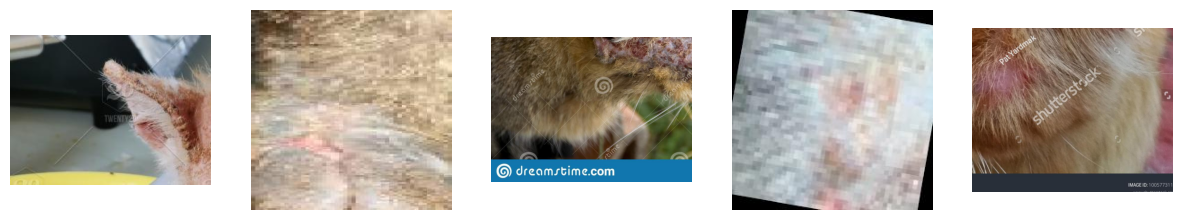


Health
Total Image :  503
Resolusi Gambar :  (640, 640, 3)


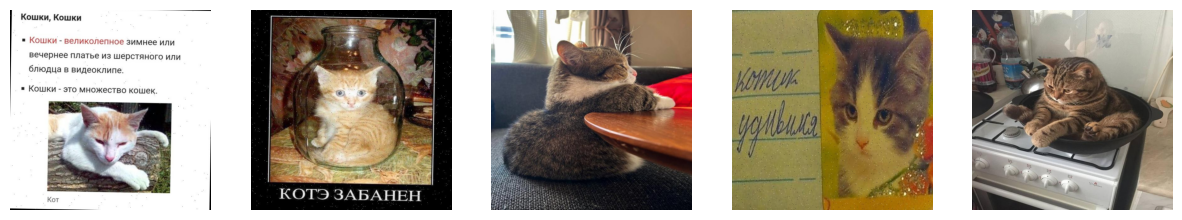


Scabies
Total Image :  509
Resolusi Gambar :  (640, 640, 3)


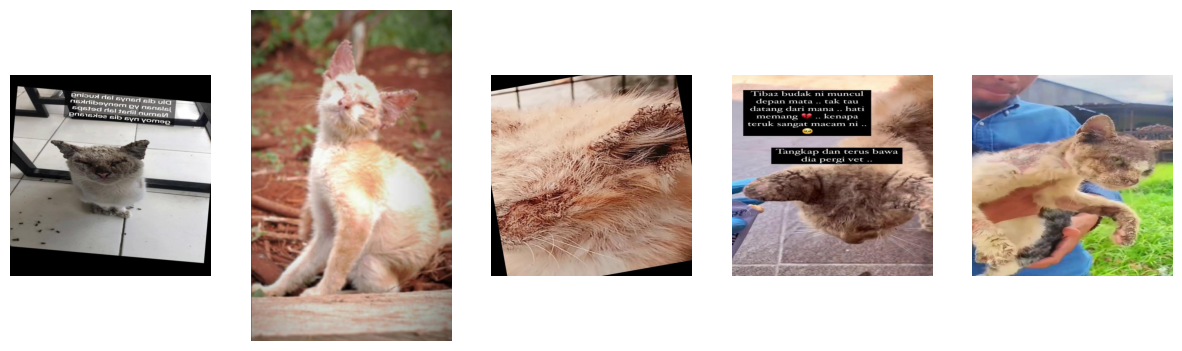


Ringworm
Total Image :  572
Resolusi Gambar :  (640, 640, 3)


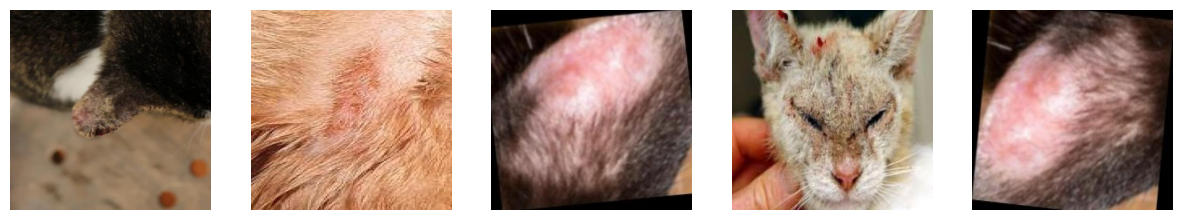

In [13]:
for item in cat_disease_classes:
    print("")
    print(item)
    class_dir = os.path.join(cat_disease, item)
    class_images = [img for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Menghitung total image di setiap kelas
    num_images = len(class_images)
    print("Total Image : ", num_images)

    # Menghitung resolusi pada gambar pertama
    img_path = os.path.join(class_dir, class_images[0])
    img = mpimg.imread(img_path)
    image_shape = img.shape
    print("Resolusi Gambar : ", image_shape)

    # Menampilkan beberapa gambar
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(class_images))):  # Tampilkan maksimum 5 gambar atau sesuai jumlah yang tersedia
        sp = plt.subplot(1, 5, i + 1)
        img = mpimg.imread(os.path.join(class_dir, class_images[i]))
        plt.axis('off')
        plt.imshow(img)
    plt.show()


# PREPOCESING DATA


Split data

In [14]:
def train_val_Dataset():
  training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
      cat_disease,
      image_size=(img_height, img_width),
      color_mode='rgb',
      batch_size= batch_size,
      label_mode='categorical',
      validation_split=0.2,
      subset='both',
      seed=42
  )

  return training_dataset, validation_dataset

In [15]:
# Membuat dataset
training_dataset, validation_dataset = train_val_Dataset()

Found 2021 files belonging to 4 classes.
Using 1617 files for training.
Using 404 files for validation.


In [16]:
# Melihat batch pertama dari image dan labels
for image_batch, labels_batch in training_dataset.take(1):
  example_batch = image_batch
  labels_batch = labels_batch

  print(f"maximum pixel value of images : {np.max(example_batch)}.\n")
  print(f"Image batch shape: {image_batch.shape}")
  print(f"Labels batch shape: {labels_batch.shape}")

maximum pixel value of images : 255.0.

Image batch shape: (64, 224, 224, 3)
Labels batch shape: (64, 4)


Augmentation

In [17]:
def create_augmentation_model():
    augmentation_model = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.3),
        tf.keras.layers.RandomZoom(0.3),
        tf.keras.layers.RandomContrast(0.3),
        tf.keras.layers.RandomBrightness(0.3),
        tf.keras.layers.RandomTranslation(0.2, 0.2),
    ])
    return augmentation_model


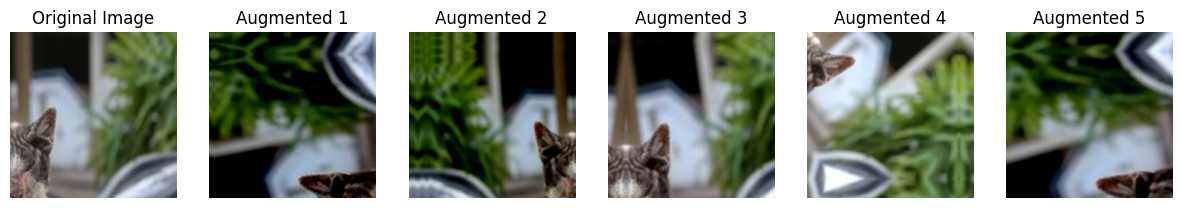

In [18]:
# Load your model for augmentation
data_augmentor = create_augmentation_model()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch[0])

images = [sample_image]

# Apply random augmentation 5 times
for _ in range(5):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 6, figsize=(15, 5))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3','Augmented 4','Augmented 5']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

# MODELING

In [19]:
def create_transfer_learning_model():
    # Load MobileNetV2 without the top layer
    base_model = MobileNetV2(
        input_shape=(img_height, img_width, 3),
        include_top=False,
        weights="imagenet"
    )

    # Freeze the base model
    base_model.trainable = False

    # Augmentation layers
    augmentation_layers = create_augmentation_model()

    # Add custom layers
    # The Input layer is added to specify the input shape explicitly
    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    x = augmentation_layers(inputs)

    # Rescale the input values
    x = tf.keras.layers.Rescaling(1./255)(x)

    # Pass the input through the pretrained base model
    x = base_model(x, training=False)

    # Add custom layers
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling
    x = Dense(128, activation='relu')(x)  # Fully connected layer
    x = BatchNormalization()(x)         # Batch normalization
    x = Dropout(0.4)(x)                 # Dropout for regularization

    # Output layer (adjust the number of units to match your class count)
    predictions = Dense(4, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=inputs, outputs=predictions)
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [20]:
create_transfer_learning_model().summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,980 (9.24 MB)

 Trainable params: 164,740 (643.52 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

Buat fungsi callback

In [21]:
class early_stopping_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs.get('accuracy')>=0.9 and logs.get('val_accuracy')>=0.9:
      print("\nReached 90% train accuracy and 90% accuracy so cancelling training!")
      self.model.stop_training = True

Mulai train model

In [22]:
history = create_transfer_learning_model().fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping_callback()]
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - accuracy: 0.3268 - loss: 2.0583 - val_accuracy: 0.4678 - val_loss: 1.1754
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.4421 - loss: 1.5415 - val_accuracy: 0.6188 - val_loss: 0.9467
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.5218 - loss: 1.2271 - val_accuracy: 0.6782 - val_loss: 0.8019
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.5611 - loss: 1.1329 - val_accuracy: 0.6980 - val_loss: 0.7357
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.6111 - loss: 0.9967 - val_accuracy: 0.7327 - val_loss: 0.6756
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.6570 - loss: 0.9679 - val_accuracy: 0.7401 - val_loss: 0.6379
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.6581 - loss: 0.9305 - val_accuracy: 0.7475 - val_loss: 0.6100
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.6825 - loss: 0.8591 - val_ac

# Hasil Model

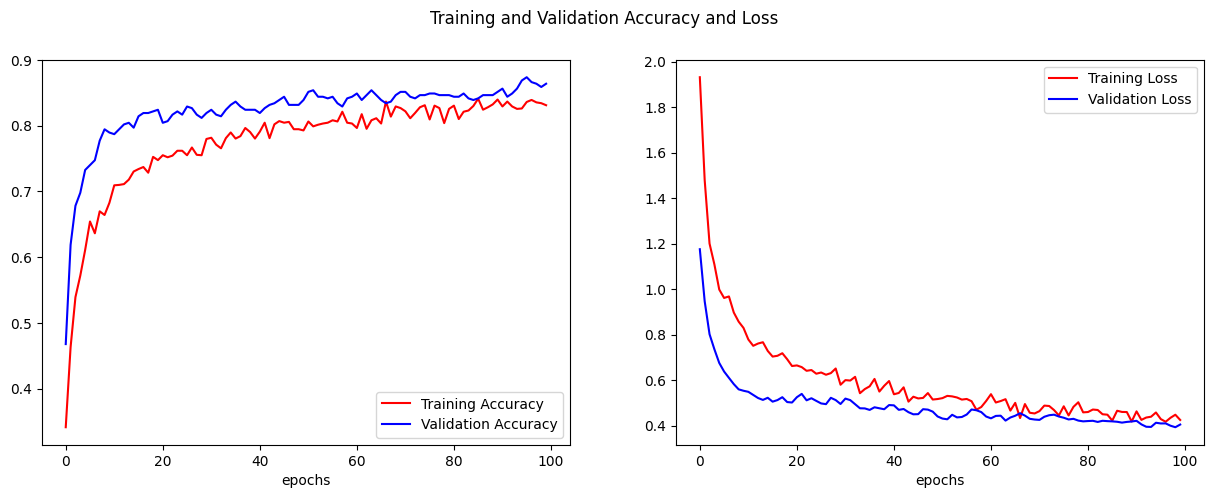

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training and Validation Accuracy and Loss')

# Define data and labels for each subplot
data_labels = [
    (acc, val_acc, 'Accuracy'),
    (loss, val_loss, 'Loss')
]

# Iterate through subplots and data
for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    axs[i].plot(epochs_range, data[0], 'r', label="Training " + label)
    axs[i].plot(epochs_range, data[1], 'b', label="Validation " + label)
    axs[i].legend()
    axs[i].set_xlabel('epochs')

plt.show()

Saving test2.jpg to test2.jpg
User uploaded file "test2.jpg" with length 7019 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Ringworm
Prediction probabilities: [[0.34480983 0.15402298 0.1558227  0.34534445]]


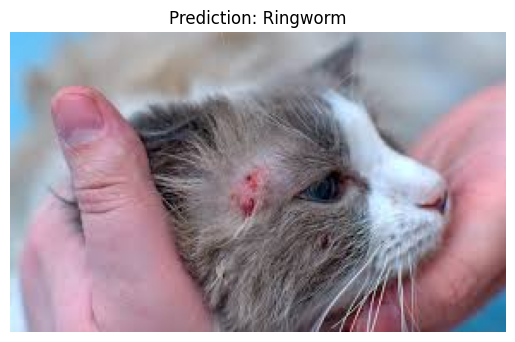

In [24]:
def predict_image(image_path, model):
    img = Image.open(image_path)
    img = img.resize((img_height, img_width))  # Resize image

    # Convert image to RGB format
    img = img.convert('RGB')  # This line is added to convert the image to RGB

    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Memprediksi kelas yang
    predicted_class_name = cat_disease_classes[predicted_class]

    return predicted_class_name, prediction


# Upload file
uploaded = files.upload()

# Informasi file yang diupload
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Membuat prediksi
image_path = fn # Menggunakan nama file yang diupload
predicted_class_name, prediction = predict_image(image_path, create_transfer_learning_model()) # Gunakan model yang telah dilatih

print(f"Predicted class: {predicted_class_name}")
print(f"Prediction probabilities: {prediction}")

# Display the uploaded image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class_name}")
plt.show()

In [ ]:
def predict_image(image_path, model):
    img = Image.open(image_path)
    img = img.resize((img_height, img_width))  # Resize image

    # Convert image to RGB format
    img = img.convert('RGB')  # This line is added to convert the image to RGB

    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Memprediksi kelas yang
    predicted_class_name = cat_disease_classes[predicted_class]

    return predicted_class_name, prediction


# Upload file
uploaded = files.upload()

# Informasi file yang diupload
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Membuat prediksi
image_path = fn # Menggunakan nama file yang diupload
predicted_class_name, prediction = predict_image(image_path, create_transfer_learning_model()) # Gunakan model yang telah dilatih

print(f"Predicted class: {predicted_class_name}")
print(f"Prediction probabilities: {prediction}")

# Display the uploaded image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class_name}")
plt.show()

# SAVE MODEL

In [ ]:
saved_model_path = "./my_model.h5"

model = create_transfer_learning_model()

model.save(saved_model_path, include_optimizer=False)

In [ ]:
# Buat model terlebih dahulu (misalnya, create_transfer_learning_model())
model = create_transfer_learning_model()

# Menyimpan arsitektur model dalam format JSON
model_json = model.to_json()

# Menyimpan ke file
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)
